# Titanic with Deep Learning    

## Setup

In [13]:
import os
import random
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision 
from torch.utils.data import DataLoader, Dataset

In [14]:
SEED = 0
csv_path = r"./data/titanic.csv"
savepath = r"./output"
device = "cuda:0"

columns = ["Pclass", "Age", "SibSp", "Parch", "Fare", "Sex", "Embarked"]

batch_size = 16
n_epochs = 100
lr = 0.01
momentum = 0.5

In [15]:
os.makedirs(savepath, exist_ok=True)

In [16]:
print("PyTorch Version: ",torch.__version__)

print("CUDA is available" if torch.cuda.is_available() else "CUDA is not available")
for i in range(torch.cuda.device_count()):
   print(torch.cuda.get_device_properties(i).name)

PyTorch Version:  2.2.1+cu121
CUDA is available
NVIDIA GeForce RTX 4070 Laptop GPU


In [17]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

class TitanicDataset(Dataset):

    def __init__(self, csv_path:str, train:bool=False, columns:list=None, val_split:float=0.2):
        self.data = pd.read_csv(csv_path)
        if columns:
            if "Survived" not in columns:
                columns.append("Survived")
            self.data = self.data[columns]

        self.scaler = StandardScaler()

        self._preprocess()

        if train:
            self.data, _ = train_test_split(self.data, test_size=val_split, random_state=SEED)
        else:
            _, self.data = train_test_split(self.data, test_size=val_split, random_state=SEED)


    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        X,y = self.data.drop(columns=["Survived"], axis=1).iloc[idx], self.data["Survived"].iloc[idx]
        return X.values, [y]

    def _preprocess(self):
        # Drop missing values if more than 20% of the values are missing
        for col in self.data.columns:
            if self.data[col].isnull().sum() > 0.0 * len(self.data):
                self.data.dropna(subset=[col], inplace=True)

            # # Fill missing values with median if numeric, mode if categorical
            # if pd.to_numeric(self.data[col], errors='coerce').notnull().all():
            #     self.data[col] = self.data[col].fillna(self.data[col].median())
            # else:
            #     self.data[col] = self.data[col].fillna(self.data[col].mode().iloc[0])
        
            # One-hot encode categorical variables
            if self.data[col].dtype == 'object':
                self.data = pd.get_dummies(self.data, columns=[col])
            
            # Scale numeric variables

    def scale(self):    
        self.data = self.scaler.fit_transform(self.data)

def collate_fn(batch):
    X, y = zip(*batch)
    X = torch.tensor(X, dtype=torch.float32)
    y = torch.tensor(y, dtype=torch.float32)
    return X, y
     

In [18]:
dataset_train = TitanicDataset(csv_path, train=True, columns=columns)
dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)

dataset_val = TitanicDataset(csv_path, train=False, columns=columns)
dataloader_val = DataLoader(dataset_val, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)

In [19]:
class NN(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim):
        super(NN, self).__init__()
        self.layer1 = nn.Linear(in_dim, hidden_dim)
        self.layer2 = nn.Linear(hidden_dim, out_dim)
    
    def forward(self, x):
        x = F.relu(self.layer1(x))
        return F.sigmoid(self.layer2(x))
    

in_dim = len(dataset_train.data.columns) - 1
hidden_dim = 3
out_dim = 1

net = NN(in_dim, hidden_dim, out_dim).to(device)

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class BigNN(nn.Module):
    def __init__(self, in_dim, hidden_dims, out_dim, dropout=0.0, use_bn=False):
        super(BigNN, self).__init__()
        self.blocks = nn.ModuleList()
        self.use_bn = use_bn

        self.in_layer = nn.Linear(in_dim, hidden_dims[0])
        for i in range(1, len(hidden_dims)):
            self.blocks.append(nn.Linear(hidden_dims[i-1], hidden_dims[i]))
            if use_bn:
                self.blocks.append(nn.BatchNorm1d(hidden_dims[i]))
            if dropout > 0:
                self.blocks.append(nn.Dropout(dropout))
        self.out_layer = nn.Linear(hidden_dims[-1], out_dim)
        
        # self._init_weights()
    
    def _init_weights(self):
        for layer in self.blocks:
            if isinstance(layer, nn.Linear):
                nn.init.normal(layer.weight, std=0.01)
                nn.init.constant_(layer.bias, 0)
        nn.init.normal(self.out_layer.weight, std=0.01)
        nn.init.constant_(self.out_layer.bias, 0)
    
    def forward(self, x):
        x = F.relu(self.in_layer(x))
        for layer in self.blocks:
            x = F.relu(layer(x))
        x = self.out_layer(x)
        return torch.sigmoid(x)

in_dim = len(dataset_train.data.columns) - 1
hidden_dims = [20, 40, 80, 40, 20, 10]
out_dim = 1

# net = BigNN(in_dim, hidden_dims, out_dim, dropout=0.1, use_bn=False).to(device)

In [ ]:
optimizer = optim.SGD(net.parameters(), lr=lr, momentum=momentum)
criterion = nn.BCELoss()

In [ ]:
train_stats = {
    "epoch": [],
    "loss": [],
}

val_stats = {
    "epoch": [],
    "acc": [],
}

In [ ]:
def train(epoch:int):
    net.train()
    running_loss = 0.0
    for i, data in enumerate(dataloader_train, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    running_loss /= len(dataloader_train)
    train_stats["epoch"].append(epoch)
    train_stats["loss"].append(running_loss)
    print(f"[Epoch {epoch+1}/{n_epochs}] Loss: {running_loss:.3f}")


def validate(epoch:int):
    net.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in dataloader_val:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = net(inputs)
            predicted = torch.round(outputs)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    acc = 100 * correct / total
    print(f"Accuracy: {acc:.2f}%")
    val_stats["epoch"].append(epoch)
    val_stats["acc"].append(acc)

In [ ]:
# Training Loop#

s_time = time.time()
for epoch in range(n_epochs):
    train(epoch)
    validate(epoch)

print(f"Training finished in {time.time() - s_time:.2f}s.")

C:\Users\ihett\AppData\Local\Temp\ipykernel_23280\3148558405.py:53: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:278.)
  X = torch.tensor(X, dtype=torch.float32)


RuntimeError: CUDA error: CUBLAS_STATUS_EXECUTION_FAILED when calling `cublasSgemm( handle, opa, opb, m, n, k, &alpha, a, lda, b, ldb, &beta, c, ldc)`

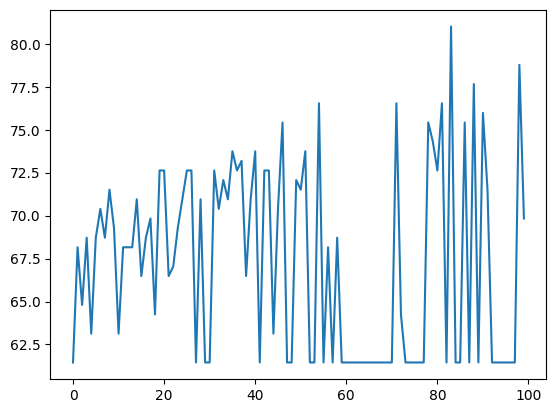

In [ ]:
# Plot
plt.figure()
plt.plot(val_stats["epoch"], val_stats["acc"], label="Accuracy")